In [53]:
import pandas as pd 
from scipy import spatial
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv("BigBasketDataset.tsv", sep="\t")

In [3]:
df.head()

,Member,Order,SKU,Created On,Description
0,M09736,6468572,34993740,22-09-2014 22:45,Other Sauces
1,M09736,6468572,15669800,22-09-2014 22:45,Cashews
2,M09736,6468572,34989501,22-09-2014 22:45,Other Dals
3,M09736,6468572,7572303,22-09-2014 22:45,Namkeen
4,M09736,6468572,15669856,22-09-2014 22:45,Sugar


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62141 entries, 0 to 62140
Data columns (total 5 columns):
Member         62141 non-null object
Order          62141 non-null int64
SKU            62141 non-null int64
Created On     62141 non-null object
Description    62141 non-null object
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


In [5]:
df.rename(columns={"Created On": "Date"}, inplace=True)

In [6]:
df.Date = pd.to_datetime(df.Date)

In [7]:
print("Number of customers:", len(df.Member.unique()))
print("Number of Orders:", len(df.Order.unique()))
print("Number of Product Designations:", len(df.Description.unique()))
print("Number of SKU:", len(df.SKU.unique()))
print("First Order:", df.Date.min())
print("Last Order:", df.Date.max())

Number of customers: 106
Number of Orders: 8387
Number of Product Designations: 216
Number of SKU: 1732
First Order: 2011-12-03 10:18:00
Last Order: 2014-10-06 14:21:00


In [8]:
import plotly.graph_objects as go
x = pd.DataFrame(df[["Member", "Order"]].groupby("Member").agg({"Order": "nunique"})).Order

fig = go.Figure(data=[go.Histogram(x=x, xbins=dict(size=10))])
fig.update_layout(title_text="Number of orders by customers", plot_bgcolor="white", showlegend=False)

fig.show()

In [9]:
x = pd.DataFrame(df[["SKU", "Order"]].groupby("Order").agg({"SKU": "nunique"})).SKU

fig = go.Figure(data=[go.Histogram(x=x, xbins=dict(size=1))])
fig.update_layout(title_text="Order size: Number of items per order", plot_bgcolor="white", showlegend=False)

fig.show()

In [10]:
bestselling_products = pd.DataFrame(df.Description.value_counts())
bestselling_products_bins = ["0-50" if i <= 50 else "51-200" if i <=200 else "201-500" if i <= 500 else "501-1000" if i <= 1000 else "1000+" for i in bestselling_products.Description.values]

fig = go.Figure(data=[go.Histogram(x=bestselling_products_bins)])
fig.update_layout(title_text="Number of items per order", plot_bgcolor="white", showlegend=False)

fig.show()

In [11]:
import plotly.express as px

fig = px.bar(y=bestselling_products.Description.values, x=bestselling_products.index)
fig.update_layout(title_text="Bestselling products", plot_bgcolor="white", showlegend=False)
fig.show()

In [12]:
# Order over time 
df["Year"] = df.Date.dt.year
y = df[["Year", "Order"]].groupby("Year").agg({"Order": "nunique"}).Order
fig = go.Figure(data=go.Scatter(x=y.index[1:], y=y[1:]))
fig.update_layout(title_text="Orders per Year", plot_bgcolor="white", showlegend=False)
fig.show()

df['MonthYear'] = pd.to_datetime(df['Date']).dt.to_period('M')
y = df[df.MonthYear != "2014-10"][["MonthYear", "Order"]].groupby("MonthYear").agg({"Order": "nunique"}).Order
fig = go.Figure(data=go.Scatter(x=y.index.astype(str), y=y))
fig.update_layout(title_text="Orders development over last year", plot_bgcolor="white", showlegend=False)
fig.show()

df["DayOfWeek"] = df.Date.dt.day_name()
y = df[["DayOfWeek", "Order"]].groupby("DayOfWeek").agg({"Order": "nunique"}).Order.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
fig = go.Figure(data=go.Scatter(x=y.index.astype(str), y=y))
fig.update_layout(title_text="Order per Weekday", plot_bgcolor="white", showlegend=False)
fig.show()

In [13]:
y= pd.DataFrame(df[df.MonthYear != "2014-10"][["SKU", "Order", "MonthYear"]].groupby(["MonthYear", "Order"]).count().SKU).reset_index()[["MonthYear", "SKU"]].groupby(["MonthYear"]).mean()

fig = go.Figure(data=go.Scatter(x=y.index.astype(str), y=y.SKU))
fig.update_layout(title_text="Development of Order Size", plot_bgcolor="white", showlegend=False)
fig.show()

y= pd.DataFrame(df[["SKU", "Order", "DayOfWeek"]].groupby(["DayOfWeek", "Order"]).count().SKU).reset_index()[["DayOfWeek", "SKU"]].groupby(["DayOfWeek"]).mean().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

fig = go.Figure(data=go.Scatter(x=y.index.astype(str), y=y.SKU))
fig.update_layout(title_text="Order size per Weekday", plot_bgcolor="white", showlegend=False)
fig.show()

In [14]:
df.Description.value_counts()[df.Description.value_counts() < 10]

Soups                        9
Flakes                       9
Paneer & Tofu                9
Other Jams                   9
Organic Branded Foods        8
                            ..
Body Lotion                  1
Tea                          1
Toilet Paper                 1
Dishwash Liquids & Pastes    1
Festive Gift Pack            1
Name: Description, Length: 76, dtype: int64

In [15]:
df["HelpCount"] = 1
bestselling_products_weekday = pd.DataFrame(df[["DayOfWeek", "Description", "HelpCount"]].groupby(["DayOfWeek", "Description"]).count()).reset_index()

In [16]:
fig = go.Figure(data=[go.Bar(x=day.Description[:15], y=day.HelpCount[:15] / day.HelpCount.sum(), name=day.DayOfWeek.values[0])
                        for day in 
                        [bestselling_products_weekday.sort_values("HelpCount",ascending=False)[bestselling_products_weekday.DayOfWeek                           == weekday]
                        for weekday in 
                        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]],           
                       )
fig.update_layout(title_text="Bestselling products by Weekday (in % of total)", plot_bgcolor="white", barmode='group', xaxis_tickangle=-45, width=1200,
    height=600,)
fig.show()

In [17]:
fig = go.Figure(data=[go.Bar(x=day.Description[:10], y=day.HelpCount[:10])
                        for day in 
                        [bestselling_products_weekday[bestselling_products_weekday.DayOfWeek == weekday].sort_values("HelpCount",                               ascending=False)
                        for weekday in 
                        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]],           
                       )

## RFQ 

In [18]:
df_rfq=df.copy()
df_rfq["Date"]=pd.to_datetime(df_rfq["Date"])
df_rfq["Date"]=pd.DatetimeIndex(df_rfq["Date"])
#Recency: Baseline data (last date in the dataset)
basedate=df_rfq.Date.max()
recency_df = df_rfq.groupby(by='Member', as_index=False)['Date'].max()
recency_df.columns = ['Member','LastOrder']
recency_df['Recency'] = recency_df['LastOrder'].apply(lambda x: (basedate - x).days)
recency_df.drop('LastOrder',axis=1,inplace=True)

#Frequency
df_temp=df_rfq.drop_duplicates(subset=['Order', 'Member'], keep="first")
#calculate frequency of orders
frequency_df = df_temp.groupby(by=['Member'], as_index=False)['Order'].count()

#Quantity
quantity_df=df_rfq.groupby(by=['Member'],as_index=False)['SKU'].count()

#Merge and rename
df_temp = recency_df.merge(frequency_df,on='Member')
df_rfq=df_temp.merge(quantity_df,on='Member')
df_rfq.rename(columns={'Order':'Frequency','SKU':'Quantity'},inplace=True)

## Modelling

In [89]:
def get_order_table(df, member, orders_since=None, orders_until=None):
    """Returns dataframe with order as rows and SKUs as columns, indicating whether SKU was bought in an order or not.
    """
    if orders_until == None:
        orders_until = df.Date.max()
    if orders_since == None:
        orders_since = df.Date.min()
    df = df.sort_values("Date")
    member_df = df[(df.Member == member) & (df.Date <= orders_until) & (df.Date >= orders_since)]
    return pd.crosstab(member_df.Order, member_df.SKU)

In [90]:
def get_rank_of_item(df, member, orders_until, sku=None):
    """
    Return the rank of the item based on the number of times the item was bought. If no sku is given, return a dataframe with skus and corresponding rank.
    """
    order_table = get_order_table(df, member, orders_until=orders_until)
    frequency = pd.DataFrame(order_table.sum().sort_values(ascending=False), columns=["bought"]).reset_index()
    if sku == None:
        return frequency
    else:
        rank = frequency[frequency.SKU == sku].index.values[0] + 1
        return rank

In [91]:
def get_days_since_last_purchase(df, member, sku):
    """
    Return days since member bought sku. 
    """
    df = df.sort_values("Date")
    # this would need to be changed to datetime.now() in production environment
    now = pd.to_datetime("2014-10-07", format="%Y-%m-%d")

    return (now - df[(df.Member == member) & (df.SKU == sku)].Date.values[-1]).seconds /60 /24

In [92]:
def square_matrix(df, member, date):
    """
    Returns a square matrix with all SKU combinations of the orders of a member and the probability that they occur together.
    """
    sliced_df = df[["Order", "SKU"]][(df.Member == member)&(df.Date<=date)]
    gps = sliced_df.groupby("Order")
    unqFet = list(set(sliced_df["SKU"]))
    final = pd.DataFrame(columns=unqFet, index=unqFet)
    final = final.fillna(0)
    for g in gps.groups.values():
        for i in range(len(g)):
            for j in range(len(g)):
                if i != j:
                    final[ sliced_df["SKU"][g[i]] ][ sliced_df["SKU"][g[j]] ] += 1
    final = final.div(final.sum(),axis=0)
    final = final.fillna(0)
    return final

In [93]:
def measure_similarity(basket1, basket2, distance):
    """ This function returns the similarity measure of two baskets.
    The metrics could be cosine similarity, jaccard- or dice coefficient.
    """
    if distance == "cosine":
        result = 1-spatial.distance.cosine(basket1, basket2)

    elif distance == "jaccard":
        result = 1-spatial.distance.jaccard(basket1,basket2)
        
    elif distance == "dice":
        result = 1-spatial.distance.dice(basket1,basket2)

    return result

In [134]:
def evaluate_recommendation(member, recommended_items, test_start_date, metric):
    test_orders = get_order_table(df, member, orders_since=test_start_date)
    recommended_order = [1 if i in recommended_items else 0 for i in test_orders.columns.values]

    similarity_scores = []
    for order_id, order in test_orders.iterrows():
        score = measure_similarity(order.values, recommended_order, metric)
        similarity_scores.append(score)
        return np.mean(similarity_scores)

In [95]:
def powerMethod(A,iter):
    n = A.shape[1]
    m = 1/n #weight of each product
    x0 = [1]*n #final vector
    delta = m*(np.array([1]*n,dtype='float64')/n) 
    for i in range(iter):
        x0 = np.dot((1-m),np.dot(A,x0)) + delta
    return pd.DataFrame(x0, columns=["page_rank"], index=A.index.values).sort_values("page_rank", ascending=False) 

In [96]:
def calculate_page_rank(df, member, orders_until, iterations=200):
    sm = square_matrix(df, member, orders_until)
    sm_transposed = sm.T 
    A = sm_transposed
    return powerMethod(A,iterations)
#calculate_page_rank(df, "M09736",  dt.datetime(2014,7,1), iterations=200)

In [97]:
def calculate_final_score(df, member, orders_until,  age_power=3):
    page_rank_scores = calculate_page_rank(df, member, orders_until)
    bestseller_ranks = get_rank_of_item(df, member, orders_until= orders_until)
    final_scores=pd.DataFrame(index=page_rank_scores.index.values, columns=["final_score"])
    for sku in page_rank_scores.index:
        page_rank = page_rank_scores.loc[sku, "page_rank"]
        age = get_days_since_last_purchase(df, member, sku)
        age_powered = age**age_power
        bestseller_rank = bestseller_ranks[bestseller_ranks.SKU == sku].index.values[0] + 1 
        final_scores.loc[sku,"final_score"] = page_rank + ((1/bestseller_rank) / age_powered) 

    return final_scores.sort_values("final_score", ascending=False)
#calculate_final_score(df, "M09736",  dt.datetime(2014,7,1), 3)

In [98]:
def get_smart_basket(df, member, orders_until, age_power=3, additional_items_perc=0):
    """Takes the final score of function "get final score" and returns a list of recommended items of each customer based on the page rank score. The length of the list can be defined by "additional_items_perc" which is the percentage above the average number of products a customer ever bought since."""
    final_scores = calculate_final_score(df, member, orders_until, age_power)
    orders = get_order_table(df, member, orders_since=None, orders_until=orders_until)
    orders["counter"] = orders.sum(axis=1)
    mean_items = orders.counter.mean()
    length = round(mean_items*(1+additional_items_perc))
    sv = final_scores.sort_values(by=["final_score"], ascending=False)#name column according to output of final score function
    smart_basket = sv.iloc[0:length,0].index.values
    return smart_basket

## Training

In [128]:
def train_model(test_start_date):
    """
    This function generates the smart basket for each member and saves them in a csv-file.
    """
    members = df[df.Date <= test_start_date].Member.unique()

    smart_baskets = pd.DataFrame(columns=["smart_basket"], index=members)
    counter = 0
    for member in members: 
        recommended_basket = get_smart_basket(df, member, orders_until=test_start_date, age_power=3, additional_items_perc=0)
        smart_baskets.loc[member, "smart_basket"] = ";".join([str(i) for i in recommended_basket])        
        print(counter, " smart baskets generated out of", len(members))
        counter += 1
    smart_baskets.to_csv("smart_baskets.csv")
train_model(dt.datetime(2014,7,1))

0  smart baskets generated out of 106
1  smart baskets generated out of 106
2  smart baskets generated out of 106
3  smart baskets generated out of 106
4  smart baskets generated out of 106
5  smart baskets generated out of 106
6  smart baskets generated out of 106
7  smart baskets generated out of 106
8  smart baskets generated out of 106
9  smart baskets generated out of 106
10  smart baskets generated out of 106
11  smart baskets generated out of 106
12  smart baskets generated out of 106
13  smart baskets generated out of 106
14  smart baskets generated out of 106
15  smart baskets generated out of 106
16  smart baskets generated out of 106
17  smart baskets generated out of 106
18  smart baskets generated out of 106
19  smart baskets generated out of 106
20  smart baskets generated out of 106
21  smart baskets generated out of 106
22  smart baskets generated out of 106
23  smart baskets generated out of 106
24  smart baskets generated out of 106
25  smart baskets generated out of 

In [127]:
smart_baskets = pd.read_csv("smart_baskets.csv", index_col=0)
basket = smart_baskets.loc[member, "smart_basket"]
basket = [int(sku) for sku in basket.split(";")]
basket

[7572306,
 15668416,
 15669856,
 7569805,
 21409124,
 34990774,
 15668468,
 15669789,
 15668381,
 15668685]

## Evaluation

In [140]:
def evaluate_baseline_model(test_start_date):
    """
    Use random items that member bought recently (last year) as recommended basket. 
    """
    members = df.Member.unique()

    similarity_scores = pd.DataFrame(columns=members)
    counter = 0
    for member in members: 
        order_table = get_order_table(df, member, orders_until=test_start_date, orders_since=test_start_date - dt.timedelta(days=360))
        avg_order_size= round(pd.DataFrame(order_table.sum(axis=1))[0].mean())

        random_choices = np.random.choice(range(len(order_table.columns.values)), avg_order_size, replace=False)
        recommended_basket = order_table.columns.values[random_choices]

        score = evaluate_recommendation(member, recommended_basket, test_start_date, "cosine")
        similarity_scores.loc[0,member] = score

        if counter % 10 == 0:
            print(counter, " members tested out of", len(members))
        counter += 1

    return similarity_scores

In [135]:
def evaluate_model(test_start_date): 
    members = df[df.Date <= test_start_date].Member.unique()
    smart_baskets = pd.read_csv("smart_baskets.csv", index_col=0)

    similarity_scores = pd.DataFrame(columns=members)
    counter = 0
    for member in members: 
        basket = smart_baskets.loc[member, "smart_basket"]
        basket = [int(sku) for sku in basket.split(";")]
        score = evaluate_recommendation(member, basket, test_start_date, "cosine") 
        similarity_scores.loc[0,member] = score

        if counter % 10 == 0:
            print(counter, " members tested out of", len(members))
        counter += 1

    return similarity_scores

In [136]:
results = evaluate_model(dt.datetime(2014,7,1))
results

0  members tested out of 106
10  members tested out of 106
20  members tested out of 106
30  members tested out of 106
40  members tested out of 106
50  members tested out of 106
60  members tested out of 106
70  members tested out of 106
80  members tested out of 106
90  members tested out of 106
100  members tested out of 106


,M09736,M39021,M47229,M76390,M77779,M78365,M78720,M82651,M84827,M86304,...,M57354,M58761,M58939,M59012,M59232,M62656,M62833,M63404,M64055,M64379
0,0.218218,0.603023,0.6742,NaN,0.426401,0,0.223607,0.196116,0.154303,0.117851,...,0.25,0.13484,0.421637,0.204124,0.478183,0.600245,0.316228,0.267261,0.400892,0.365148


In [141]:
baseline = evaluate_baseline_model(dt.datetime(2014,7,1))
baseline

0  members tested out of 106
10  members tested out of 106
20  members tested out of 106
30  members tested out of 106
40  members tested out of 106
50  members tested out of 106
60  members tested out of 106
70  members tested out of 106
80  members tested out of 106
90  members tested out of 106
100  members tested out of 106


,M09736,M39021,M47229,M76390,M77779,M78365,M78720,M82651,M84827,M86304,...,M57354,M58761,M58939,M59012,M59232,M62656,M62833,M63404,M64055,M64379
0,0,0.174078,0.301511,0,0,0,0.204124,0,0.408248,0.408248,...,0,0,NaN,0,0.312348,0.433861,0.365148,0.176777,0.176777,0


In [142]:
results.loc[0,:].mean()

0.3013103606596406

In [143]:
baseline.loc[0,:].mean()

0.12610231632975216

## Did you forget

In [340]:
def did_you_forget(df, n, member, current_basket,date, use_recommended_list = False, distance = "jaccard"):
    """
    Takes a member and the latest date to suggest products that the client may have forgotten.
    If use_recommended_list is True, then it returns the n products based on their page rank score and are missing
    from the current basket.
    If use recommended_list is False, then it computes the similarity to all the client's previous orders and returns
    items suggestion based on the previous order with the highest similarity.
    """
    
    if use_recommended_list == True:
        best_recommendation = get_smart_basket(df, member,date, additional_items_perc=0.5)
        recommender = [x for x in best_recommendation if x not in current_basket]
        recommender = recommender[:n]
    else:
        test_orders = get_order_table(df, member, orders_since=test_start_date)
        current_list = [1 if i in current_basket else 0 for i in test_orders.columns.values]
        
        final_score = 0
        final_order = 0
        for order_id, order in test_orders.iterrows():
            score = measure_similarity(order.values, current_list, distance)
            if score > final_score:
                final_score = score
                final_order = order
        order = order.index[order !=0]
        recommender = [x for x in order if x not in current_basket]
        b = len(recommender)
        if n > b:
            recommender = recommender[:b]
        else:
            recommender = recommender[:n]

    return recommender

In [341]:
current_basket = df[(df.Member=="M09736")&(df.MonthYear == "2014-09")].SKU.head(12).to_list() #test order

did_you_forget(df, 5, "M09736", current_basket, "2014-08", use_recommended_list = True)

[7572306, 15668416, 15669789, 15668468, 7569805]

In [342]:
did_you_forget(df, 5, "M09736", current_basket, "2014-08")

[7572306, 7623116, 15668379, 15669764, 15669772]

# Bonus Challenge

In [343]:
def smart_basket(df, weight_max = 0.9, weight_min= 0.1):
    sort_date=df.sort_values("Date")
    f_order=[]
    n_return = []
    for member in sort_date.Member.unique():
        f_order.append(sort_date[sort_date['Member'] == member].Order.unique()[0])
        n_return.append(len(sort_date[sort_date['Member'] == member].Order.unique())-1)
    f_order= pd.DataFrame(f_order, columns=["First_Order"], index=sort_date.Member.unique())
    f_order["N_return"] = n_return
    valuable_c = f_order[f_order["N_return"]>= f_order.N_return.mean()].index.values
    
    sku_buy= pd.DataFrame(columns=["sku","imp"])
    for order in f_order.First_Order:
        l_sku = df[df['Order'] == order].loc[:,['Member','Order','SKU']].SKU
        for sku in l_sku: 
            if f_order[f_order['First_Order']==order].index.values in valuable_c:
                sku_buy= sku_buy.append({'sku':sku,'imp':1},ignore_index=True)
            else:
                sku_buy= sku_buy.append({'sku':sku,'imp':0},ignore_index=True)
    count_c = {i:sku_buy.sku.tolist().count(i)* weight_max if 1 in (sku_buy[sku_buy['sku']== i].imp).tolist() else sku_buy.sku.tolist().count(i)* weight_min for i in sku_buy.sku.tolist() if 1 in (sku_buy[sku_buy['sku']== i].imp).tolist()}
    best_sku= pd.DataFrame.from_dict(count_c, orient='index', columns=["NumberOfCoocurence"]).sort_values("NumberOfCoocurence", ascending=False)
    best_sku.NumberOfCoocurence = (best_sku.NumberOfCoocurence)/best_sku.size
    return best_sku

smart_basket(df)

,NumberOfCoocurence
15668468,0.116547
15668379,0.110072
15668688,0.103597
15668416,0.103597
15669878,0.097122
...,...
7573410,0.006475
92956738,0.006475
7601962,0.006475
7572981,0.006475


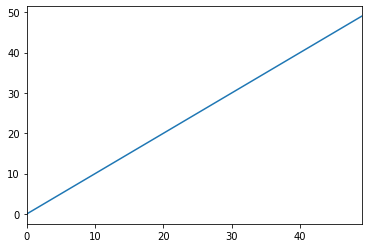

In [33]:
x = [i for i in range(0,50)]
pd.Series(x).plot()
plt.show()

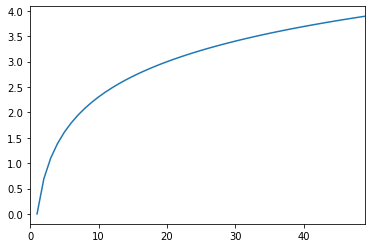

In [35]:
x1 = [np.log(i) for i in x ]
pd.Series(x1).plot()
plt.show()

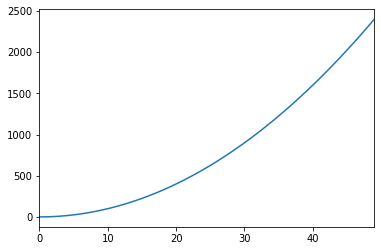

In [36]:
x2 = [i**2 for i in x ]
pd.Series(x2).plot()
plt.show()